# SLP

In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

## Create and print the training dataset

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dtatset:\n", train_dataset)

Print the training dtatset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


## Create and print the validating dataset

In [4]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Plot multiple training data

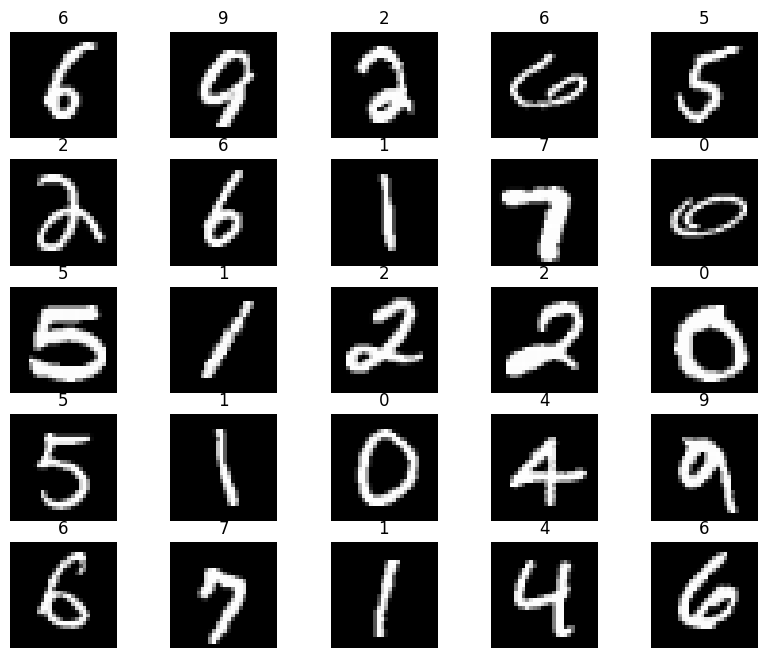

In [5]:
h = plt.figure(figsize=(10,8))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    random_idx = torch.randint(len(train_dataset), size=(1,)).item() 
    img, label = train_dataset[random_idx]
    h.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

# Define SLP-Model

In [ ]:
class SLP(nn.Module):
    # Contructor
    def __init__(self, input_size, output_size):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    # Prediction
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

In [6]:
input_dim = 28*28
output_dim = 10

## Set GPU if device is possible

In [7]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
if device !="cuda":
    device = "mps" if torch.backends.mps.is_available() else "cpu"

## Create Model

In [8]:
model = SLP(input_dim, output_dim).to(device)
print('The model: \n', model)

The model: 
 SLP(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## View the size of the model parameters

In [9]:
print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


In [10]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-1.8425e-02, -3.4410e-02,  2.6195e-02,  ...,  1.8167e-02,
                        2.7001e-02, -1.1546e-02],
                      [-2.0918e-02, -1.5521e-03,  9.3169e-03,  ...,  3.0474e-02,
                       -7.7749e-03, -2.6012e-02],
                      [-2.6125e-03, -1.8245e-02,  1.0371e-02,  ...,  2.8439e-03,
                       -2.7134e-02,  2.7449e-02],
                      ...,
                      [ 1.2349e-02, -2.9483e-02, -3.5563e-02,  ..., -2.9390e-02,
                       -1.1684e-02, -3.1023e-02],
                      [-1.5778e-02, -4.9199e-03, -2.4594e-02,  ...,  2.3712e-02,
                       -1.4346e-03,  3.2265e-02],
                      [-4.0849e-03, -1.9675e-02, -7.1591e-03,  ...,  2.0996e-04,
                        5.2981e-03,  9.6109e-05]])),
             ('linear.bias',
              tensor([ 0.0126, -0.0192,  0.0270, -0.0028,  0.0189, -0.0004,  0.0089, -0.0042,
                       0.0085,

In [11]:
print('W: ', model.state_dict()['linear.weight'].size())
print('b: ', model.state_dict()['linear.bias'].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


## Helper Function

In [12]:
def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data.cpu()
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel(f"class: {i}")

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

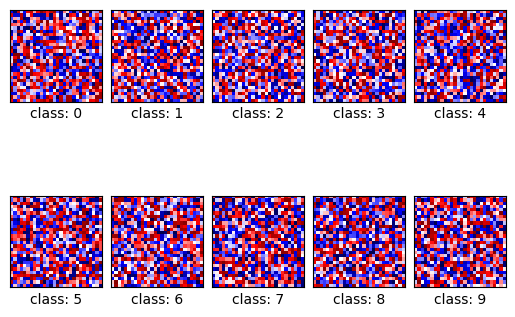

In [13]:
PlotParameters(model=model)

## Define the learning_rate, optimizer, criterion and data loader

In [14]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [15]:
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0, 0
    for batchNr, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # set previously used gradient calues to zero
        optimizer.zero_grad()

        # flatten input matrix and compute prediction error
        pred = model(X.view(-1, input_dim))
        loss = loss_func(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # The following lines are calculating the accuracy values
        _, yhat = torch.max(pred.data, 1)
        correct += (yhat == y).sum().item()
        train_loss += loss
        if (batchNr+1) %100 == 0:
            loss, current = loss.item(), (batchNr+1)*len(y)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    accuracy = correct / size
    train_accuracy_list.append(accuracy)
    loss_list.append(train_loss.item()/size)

In [16]:
val_loss_list = []
val_accuracy_list = []

# perform a prediction on the validationdata 
def validate(dataloader, model, loss_func):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    #print(num_batches)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for x_test, y_test in dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            pred = model(x_test.view(-1, input_dim))
            val_loss += loss_func(pred, y_test)
            # The following lines are calculating the accuracy values
            _, yhat = torch.max(pred.data, 1)
            correct += (yhat == y_test).sum().item()
    val_loss /= num_batches  
    accuracy = correct / size
    val_accuracy_list.append(accuracy)
    val_loss_list.append(val_loss.item())
    print(f"Validation Error: \n Accuracy: {(100*accuracy):>0.1f} Avg loss: {(val_loss.item()):>8f}")

In [17]:
n_epochs = 10
loss_list = []
train_accuracy_list = []
N_test = len(validation_dataset)
print(N_test)
print(len(train_loader.dataset))

for t in range(n_epochs):
    print(f"\nEpoch {t+1}\n---------------------------------------------")
    train(train_loader, model, loss_func, optimizer)
    validate(validation_loader, model, loss_func)
print("Done")

10000
60000

Epoch 1
---------------------------------------------
loss: 0.647488 [10000/60000]
loss: 0.635415 [20000/60000]
loss: 0.688662 [30000/60000]
loss: 0.521208 [40000/60000]
loss: 0.493918 [50000/60000]
loss: 0.411046 [60000/60000]
Validation Error: 
 Accuracy: 90.3 Avg loss: 0.364688

Epoch 2
---------------------------------------------
loss: 0.235934 [10000/60000]
loss: 0.360433 [20000/60000]
loss: 0.507561 [30000/60000]
loss: 0.402960 [40000/60000]
loss: 0.391061 [50000/60000]
loss: 0.334381 [60000/60000]
Validation Error: 
 Accuracy: 91.4 Avg loss: 0.310850

Epoch 3
---------------------------------------------
loss: 0.200936 [10000/60000]
loss: 0.298998 [20000/60000]
loss: 0.456397 [30000/60000]
loss: 0.361160 [40000/60000]
loss: 0.348447 [50000/60000]
loss: 0.307317 [60000/60000]
Validation Error: 
 Accuracy: 91.7 Avg loss: 0.291517

Epoch 4
---------------------------------------------
loss: 0.190076 [10000/60000]
loss: 0.271474 [20000/60000]
loss: 0.429292 [30000/6000

## Plot the loss and accuracy

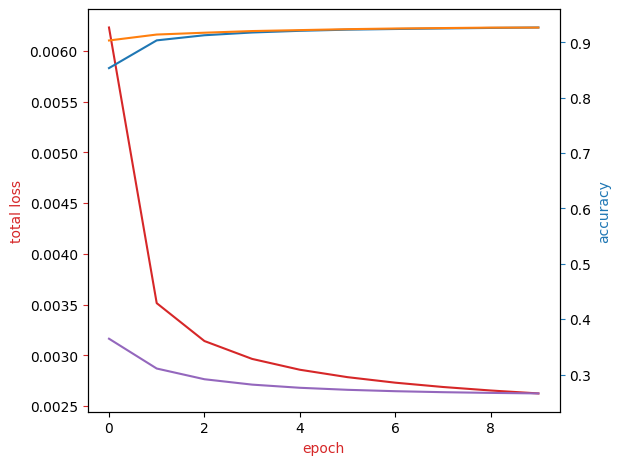

In [18]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( train_accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

color = 'tab:orange'
ax2.plot(val_accuracy_list, color=color)

color = 'tab:purple'
ax2.plot(val_loss_list, color=color)

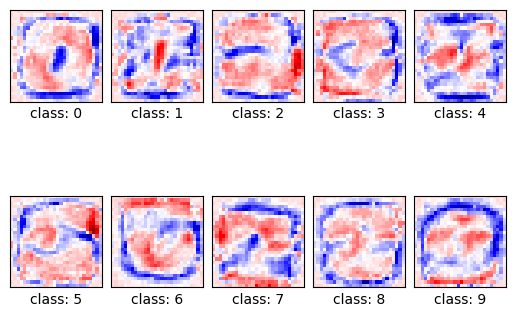

In [19]:
PlotParameters(model)

In [20]:
# Plot the data
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().squeeze(), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [21]:
Softmax_fn=nn.Softmax(dim=1)

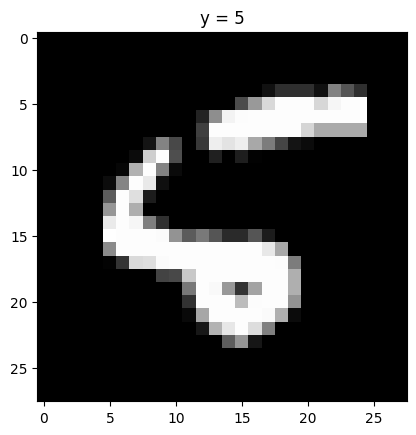

yhat: 6
probability of class  0.9983124732971191
index:  8


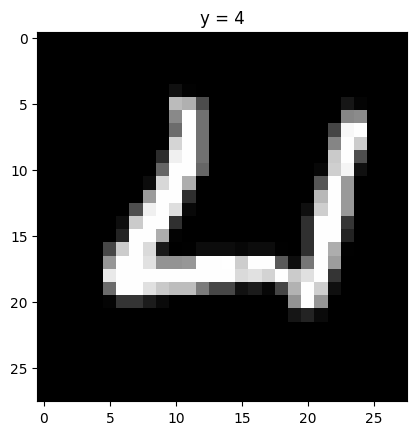

yhat: 0
probability of class  0.47368115186691284
index:  33


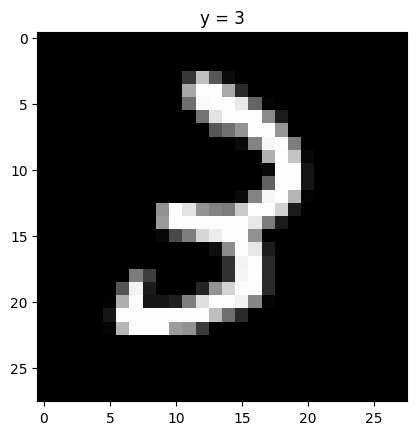

yhat: 2
probability of class  0.7069295048713684
index:  63


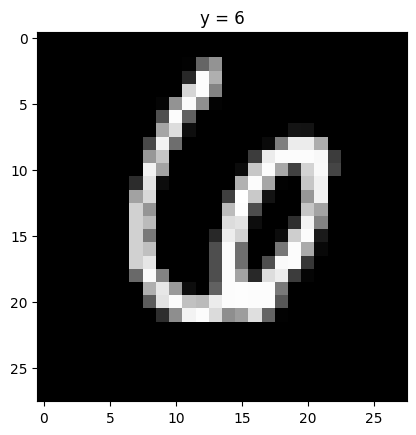

yhat: 2
probability of class  0.4123383164405823
index:  66


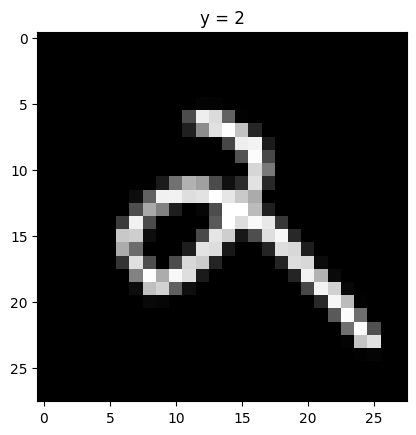

yhat: 9
probability of class  0.9425148367881775
index:  149


In [22]:
count, k = 0, -1
for X, y in validation_dataset:
    k +=1
    X = X.to(device)
    y = torch.from_numpy(np.array([[y]]))
    y = y.to(device)
    z = model(X.reshape(-1, input_dim))
    _, yhat = torch.max(z, 1)
    yhat = int(yhat.item())
    if yhat != y:
        X, y = X.cpu(), y.cpu()
        show_data((X, y.item()))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        print('index: ', k)
        count += 1
    if count >= 5:
        break

tensor([[-4.3226, -3.8411,  4.1548,  3.1598, -5.1744, -2.9765, -4.1011, -9.1433,
          0.9609, -1.9920]])

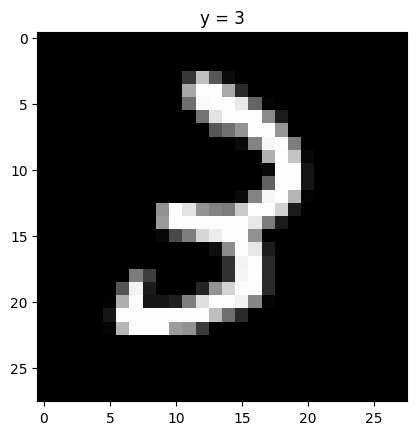

In [23]:
X, y = validation_dataset[63]
show_data((X, y))
#X, y = X.cpu(), y.cpu()
Weights = model.state_dict()['linear.weight'].data.cpu()
bias = model.state_dict()['linear.bias'].data.cpu()
torch.transpose(torch.matmul(Weights, X.view(input_dim, -1)), 1, 0) + bias
#Softmax_fn(torch.transpose(torch.matmul(Weights, X.view(input_dim, -1)), 1, 0) + bias)